In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [2]:
# pd.set_option('display.max_rows', 20)

data = pd.read_csv('../data/train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
data.shape

(1460, 81)

In [4]:
numerical = [f for f in data.columns if data.dtypes[f] != 'object']
numerical.remove('SalePrice')
numerical.remove('Id')
categorical = [f for f in data.columns if data.dtypes[f] == 'object']

# Although this column has numerical values, the true meaning of them is just a categorization to identify
# the type of dwelling involved in the sale. Because of that, I will transfer it to the categorical list
numerical.remove("MSSubClass")
categorical.append("MSSubClass")

# O mesmo o corre com as seguintes categorias, que são numéricas (indo de 0 a 10) porém elas são mais subjetivas e 
# categoricas.
numerical.remove("OverallQual")
numerical.remove("OverallCond")
categorical.append("OverallQual")
categorical.append("OverallCond")

print("Number of categorical columns: {}".format(len(categorical)))
print("Number of numerical columns: {}".format(len(numerical)))

Number of categorical columns: 46
Number of numerical columns: 33


In [5]:
def missing(columns):
    missing = data[columns].isnull().sum()
    missing = missing[missing > 0]
    missing.sort_values(ascending=False, inplace=True)
    return missing

def plot_nan(data, **kwargs):
    sns.set_theme(style="whitegrid", context="talk")
    f, ax1 = plt.subplots(1, 1, figsize=(10, 7))
    sns.barplot(x=data.values, y=data.index, palette="winter_r", ax=ax1, orient="h", **kwargs)
    sns.set(font_scale=2)
    ax1.set_xlabel("Number of NaN values")
    plt.plot()
    
def plot_dist(data, figsize=(10, 7), **kwargs):
    sns.set_theme(style="ticks", context="talk")
    f, ax1 = plt.subplots(1, 1, figsize=figsize)
    sns.histplot(data, color="g", ax=ax1, kde=True, line_kws={"lw":3}, **kwargs)
    sns.set(font_scale=2)
    plt.plot()

def box_plot(x, y, data, figsize=(9, 7), **kwargs):
    plt.subplots(figsize=figsize)
    sns.set_theme(style="whitegrid", context="talk")
    sns.set(font_scale=2)
    sns.boxplot(x=x, y=y, data=data[[x, y]], **kwargs)
    plt.xlabel(x, size=15)
    plt.ylabel(y, size=15)
    plt.plot()

def scatter_plot(x, y, data,figsize=(9, 7), **kwargs):
    plt.subplots(figsize=figsize)
    sns.set_theme(style="whitegrid", context="talk")
    sns.set(font_scale=2)
    sns.scatterplot(x=x, y=y, data=data, **kwargs)
    plt.xlabel(x, size=15)
    plt.ylabel(y, size=15)
    plt.plot()
    
def triang_corr_plot(corr, figsize=(18, 18), mask=True, square=True, cmap=False, **kwargs):
    f, ax = plt.subplots(figsize=figsize)
    if mask:
        mask = np.triu(np.ones_like(corr, dtype=bool))
    else:
        mask = np.zeros_like(corr, dtype=bool)
    
    if not cmap:
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        
    sns.set(font_scale=2)
    sns.heatmap(corr,square=square, mask=mask, cmap=cmap, linewidths=.1, cbar_kws={"shrink": .5}, **kwargs)
    plt.plot()


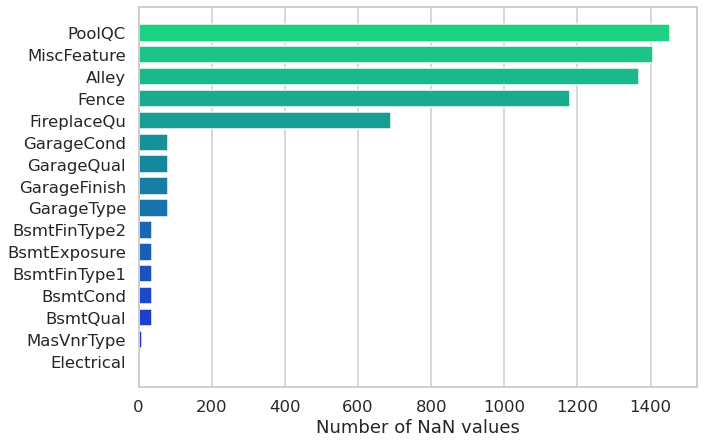

In [6]:
cat_miss = missing(categorical)
plot_nan(cat_miss)

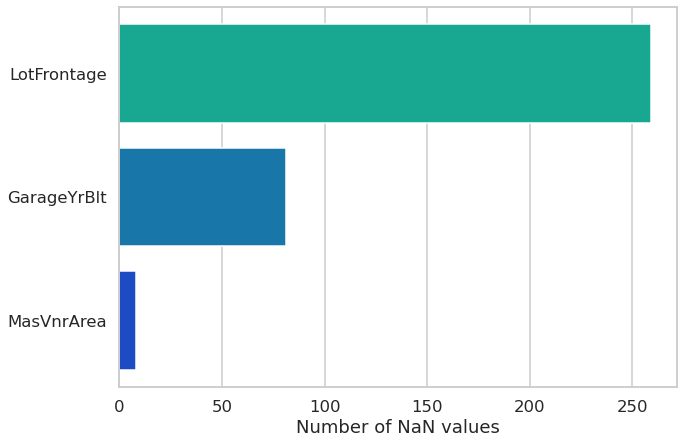

In [7]:
num_miss = missing(numerical)
plot_nan(num_miss)

The data description for **PoolQ**, **MiscFeature**, **Alley**, **Fence**, **FireplaceQu**, **GarageCond**, **GarageQual**, **GarageFinish**, **GarageType**, **BsmtFinType2**, **BsmtExposure**, **BsmtFinType1**, **BsmtCond**, and **BsmtQual**, says clearly that the NaN values stand for No Pool, No alley access, No Garage and so on. Because of that we are going to substitute all NaN in those categorical atributes for "None". Besides that, there is a NaN value in **MasVnrType**, and e will substitute for "None" too, seeing that this class already exist.

Also, the one record that has a NaN in the **Electrical** atribute will be droped, because one record will not affect the regression algorithms.

Finally, the NaN values in the **LotFrontage**, **GarageYrBlt** and **MasVnrArea** will be set to zero because they are numerical columns.

In [8]:
data.dropna(subset=['Electrical'], inplace=True)
for atribute in categorical:
    data[atribute] = data[atribute].fillna('None')
    
for atribute in numerical:
    data[atribute] = data[atribute].fillna(0)

In [11]:
data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


Kurtosis: 6.529263049673958
Skewness: 1.8819429948035529


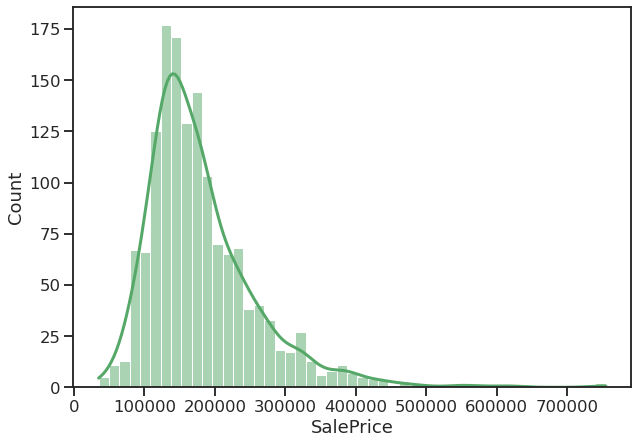

In [12]:
plot_dist(data["SalePrice"])
print("Kurtosis:", data["SalePrice"].kurt())
print("Skewness:", data["SalePrice"].skew())

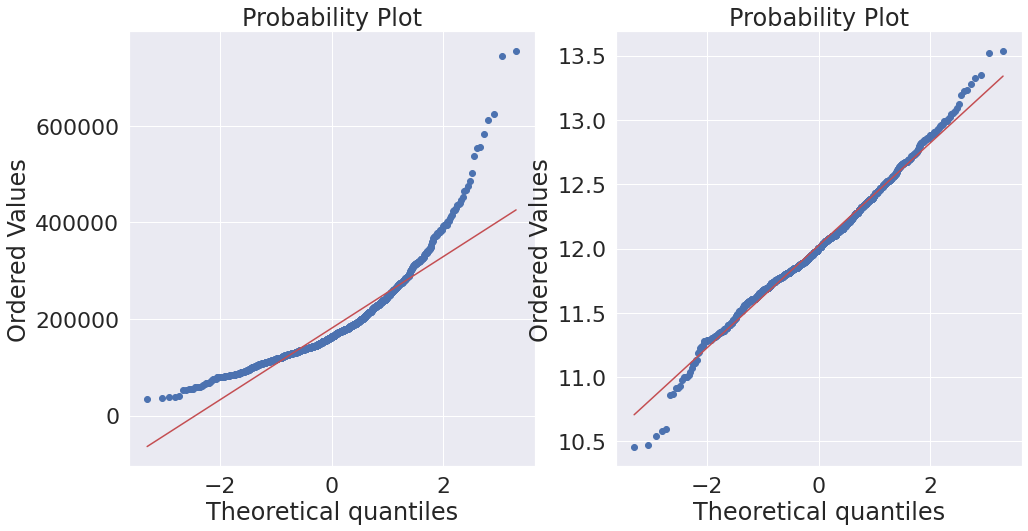

In [13]:
f,ax = plt.subplots(1,2,figsize=(16,8))
stats.probplot(np.log(data["SalePrice"]), plot=ax[1])
stats.probplot(data["SalePrice"],plot=ax[0])
plt.show()

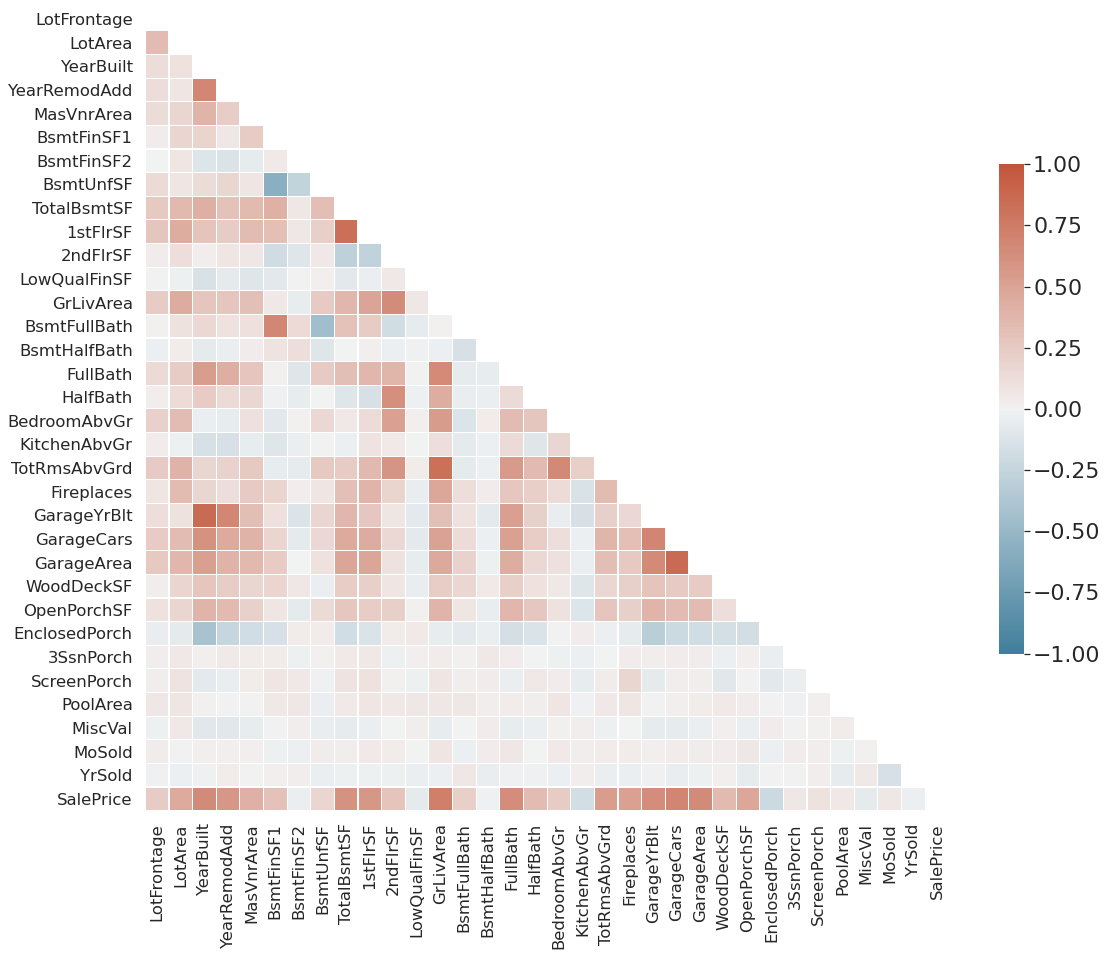

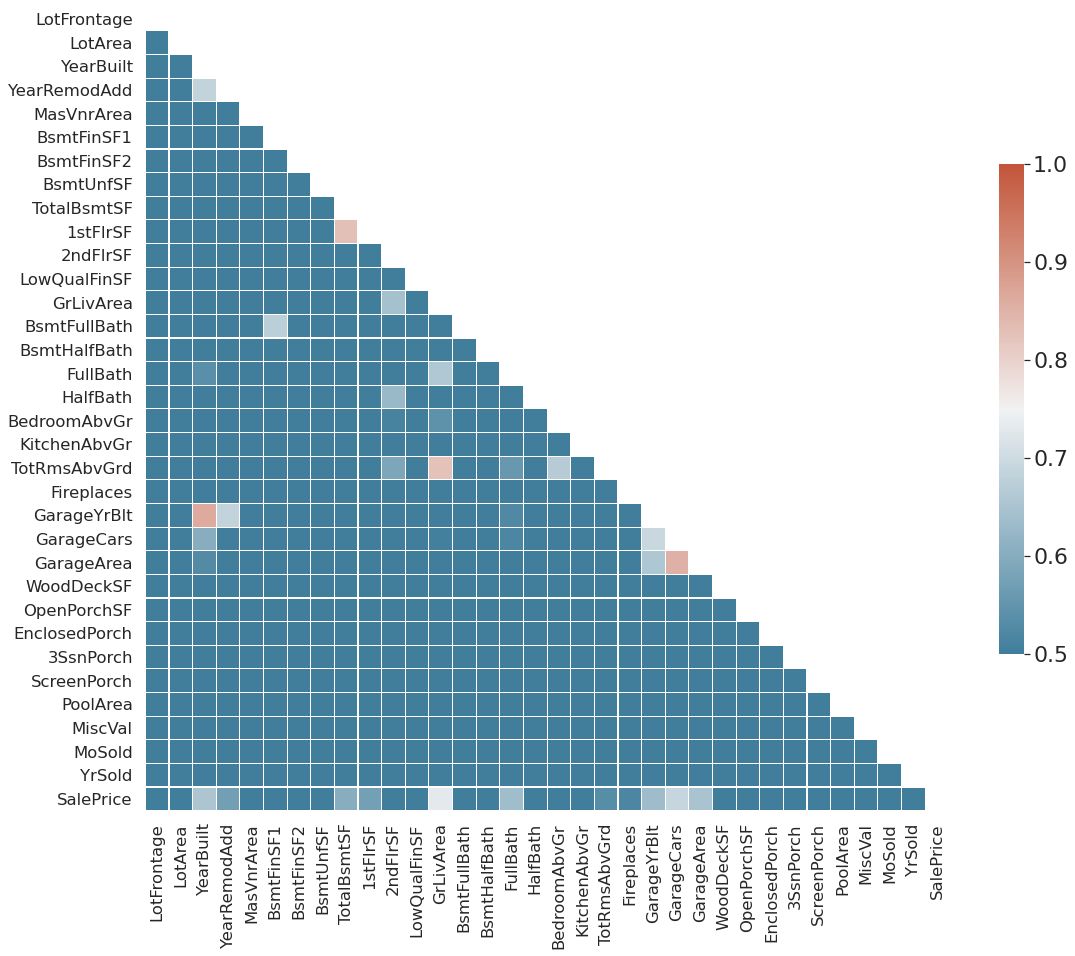

In [14]:
corr_num = data[numerical+["SalePrice"]].corr(method="spearman")
sns.set_theme(style="whitegrid", context="talk")
triang_corr_plot(corr_num, vmax=1, vmin=-1)
sns.set_theme(style="whitegrid", context="talk")
triang_corr_plot(corr_num, vmax=1, vmin=0.5)

In [15]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
cat_encoded = []
for q in categorical:  
    encode(data, q)
    cat_encoded.append(q+'_E')
print(cat_encoded)



['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E', 'MSSubClass_E', 'OverallQual_E', 'OverallCond_E']


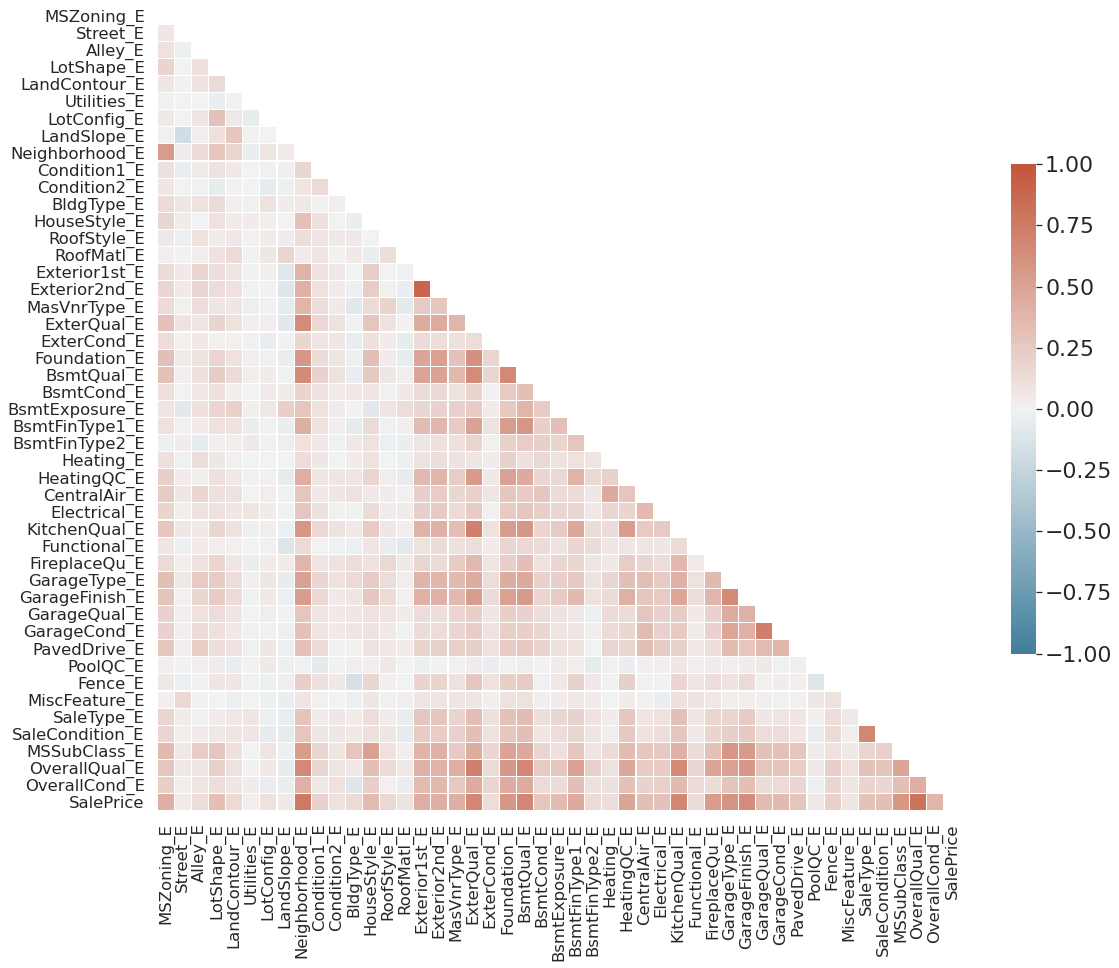

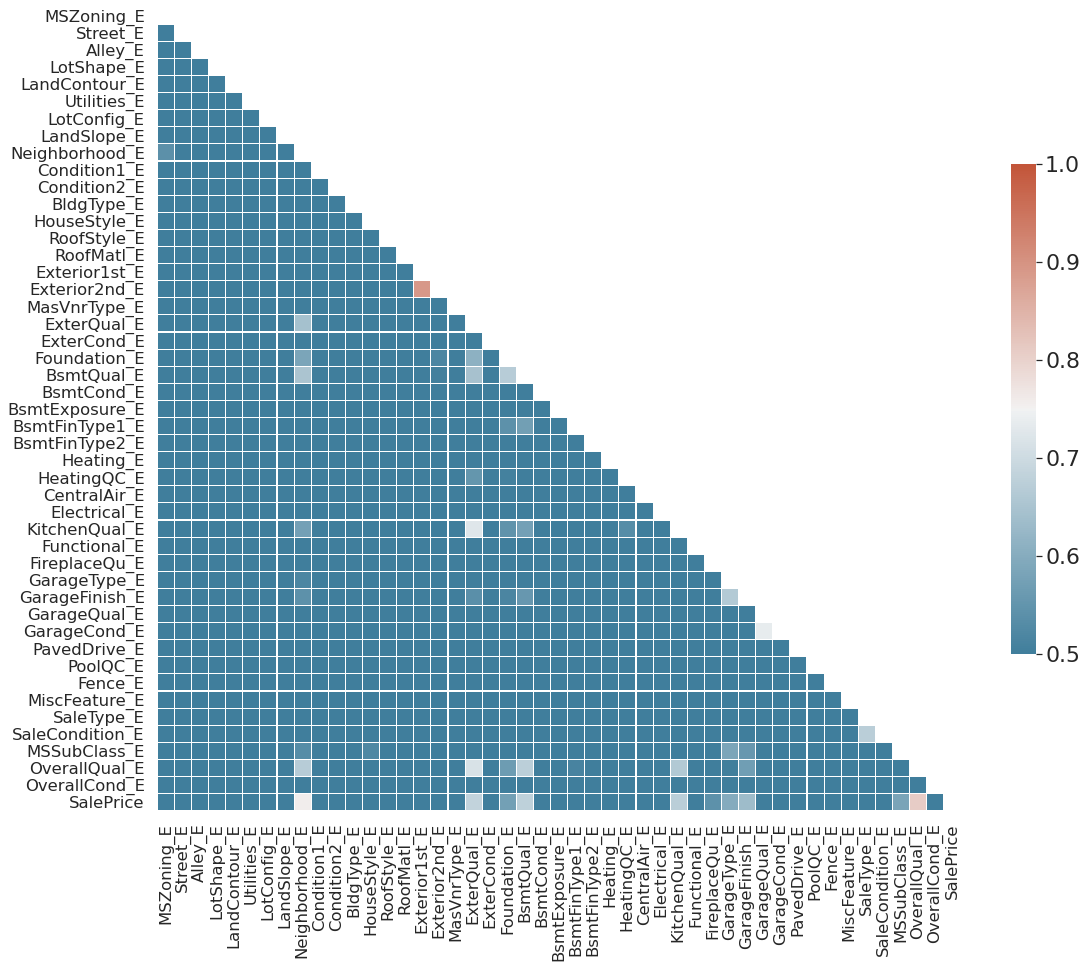

In [23]:
corr_cat = data[cat_encoded+["SalePrice"]].corr(method="spearman")
sns.set_theme(style="whitegrid", context="talk")
triang_corr_plot(corr_cat, vmax=1, vmin=-1)
sns.set_theme(style="whitegrid", context="talk")
triang_corr_plot(corr_cat, vmax=1, vmin=0.5)

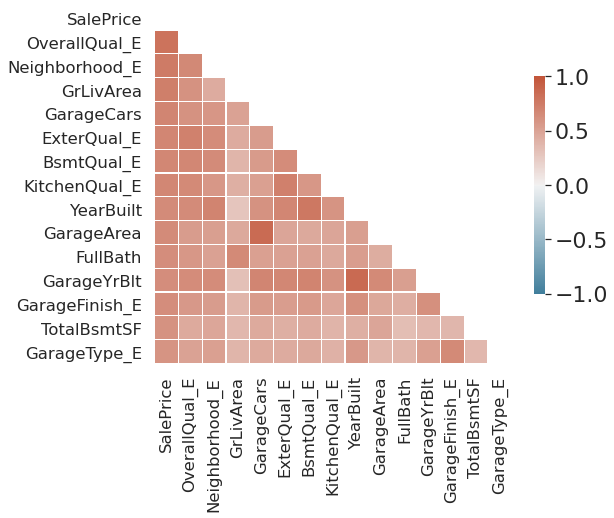

In [26]:
top_6_num = corr_num["SalePrice"].sort_values(ascending=False)[:8]
top_6_cat = corr_cat["SalePrice"].sort_values(ascending=False)[1:8]
top_12 = top_6_cat.append(top_6_num).sort_values(ascending=False).index

corr_12 = data[top_12].corr(method="spearman")
sns.set_theme(style="whitegrid", context="talk")
triang_corr_plot(corr_12, vmax=1, vmin=-1, figsize=(8, 8))

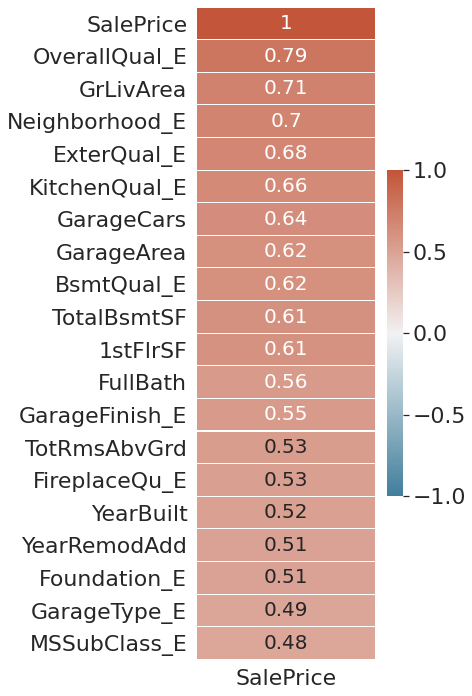

In [27]:
corr_SalePrice = data[numerical + cat_encoded + ["SalePrice"]].corr()
triang_corr_plot(corr_SalePrice[['SalePrice']].sort_values(by=['SalePrice'],ascending=False).head(20), 
                 vmax=1, vmin=-1, figsize=(4, 12), mask=False, annot=True, annot_kws={"size": 20}, square=False)

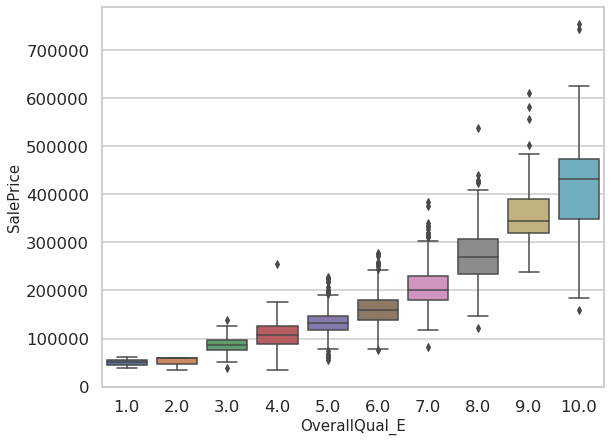

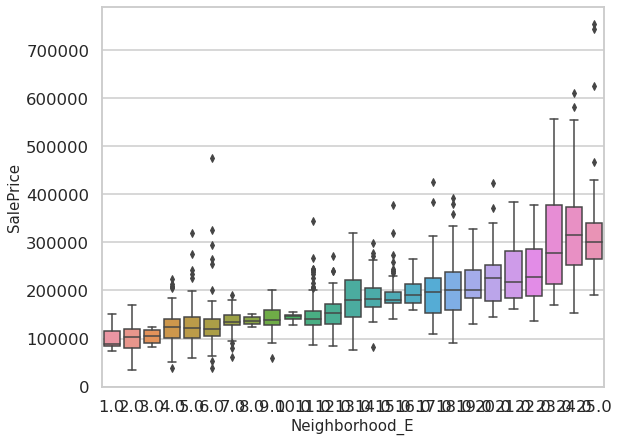

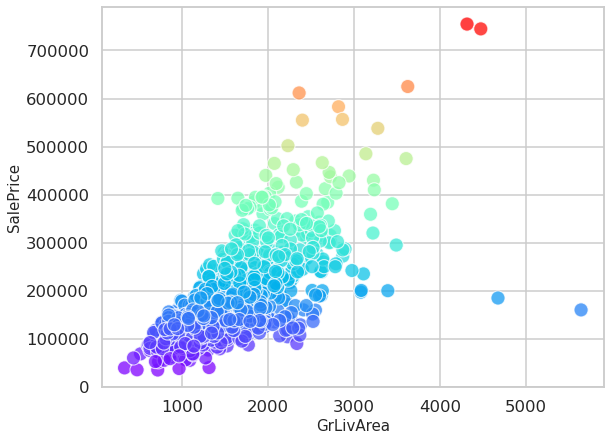

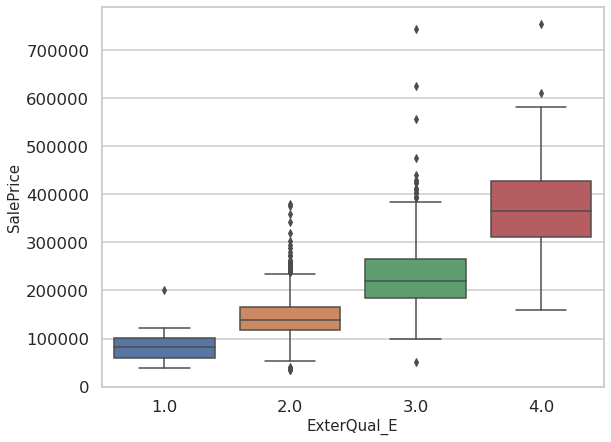

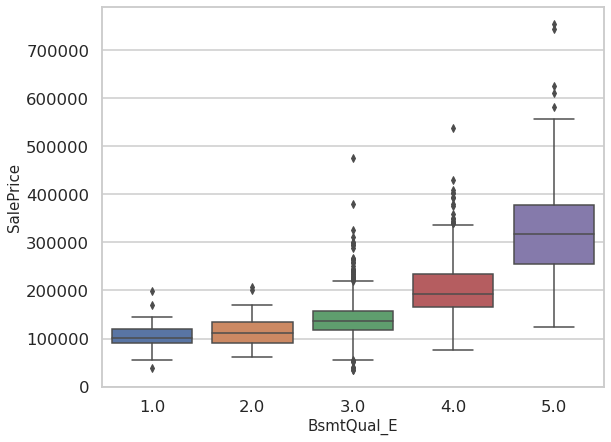

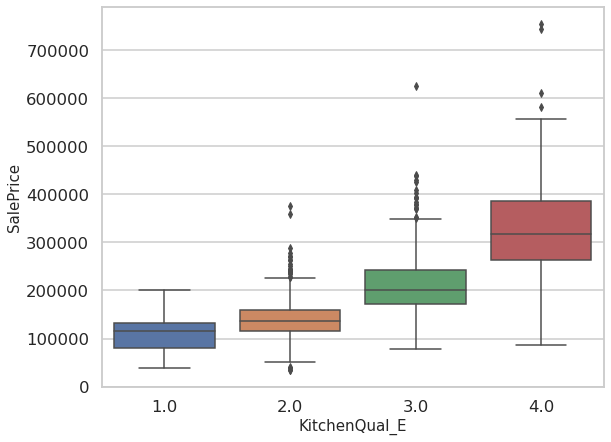

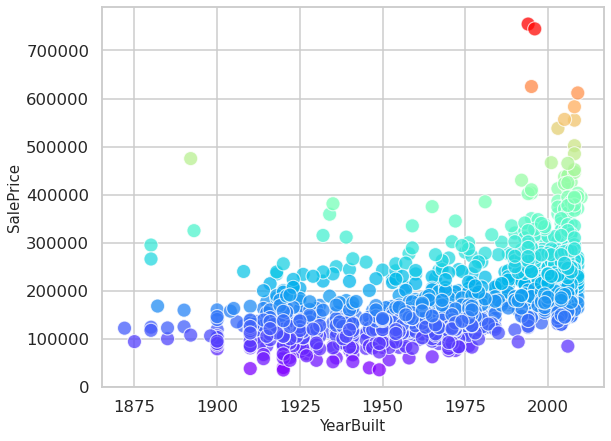

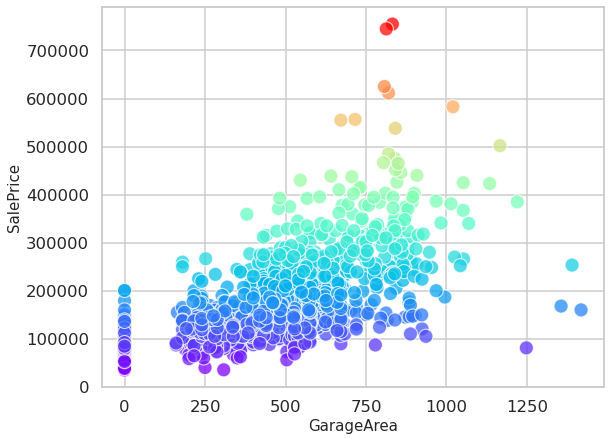

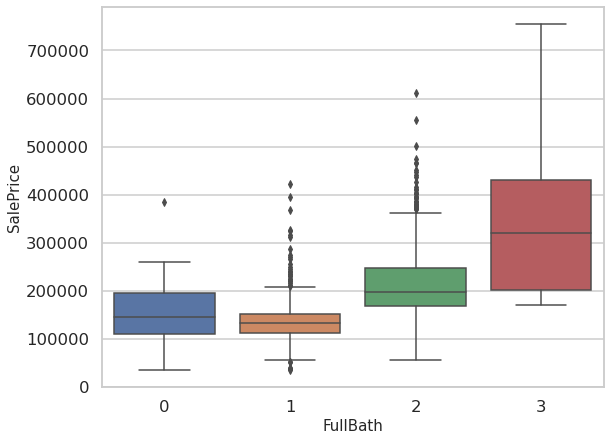

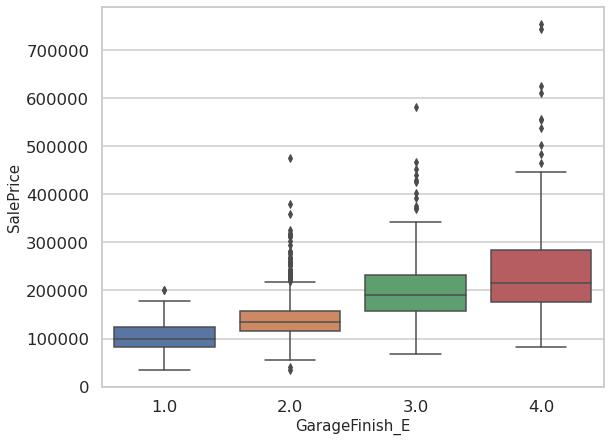

In [21]:
for i in range(1, top_12.size):
    if top_12[i] == "GarageCars" or top_12[i] == "GarageYrBlt":
        continue
    elif top_12[i][-1] == "E" or top_12[i] == "FullBath":
        sns.set_theme(style="whitegrid", context="talk")
        box_plot(top_12[i], "SalePrice", data[[top_12[i], "SalePrice"]])
    else:
        sns.set_theme(style="whitegrid", context="talk")
        scatter_plot(top_12[i], "SalePrice", data[[top_12[i], "SalePrice"]], s=200, alpha=0.75, 
                     edgecolors="face", hue="SalePrice",palette="rainbow", legend=False)

Aqui a gente pode ver algumas correlações positivas muito for fortes entre variáveis numéricas. Muitas delas são bem óbvias, como a correlação forte entre GarageArea e GarageCars, uma vez que quanto mais carros couberem na garagem, maior será sua área. Há também uma correlação entre TotRmsAbvGrd e GrLivArea, novamente, quanto mais salas, maior a area total de um edificio tente a ter. O mesmo pode ser observado entre a correlação do 1stFlrSF e TotalBsmtSF, já que o basement costuma ter a mesma area da casa.

Partindo para alumas correlações mais descritivas dos dados, nós temos a relação entre o GarageYrBlt e as GarageCars, algo que pode ser interessante de se visualizar.


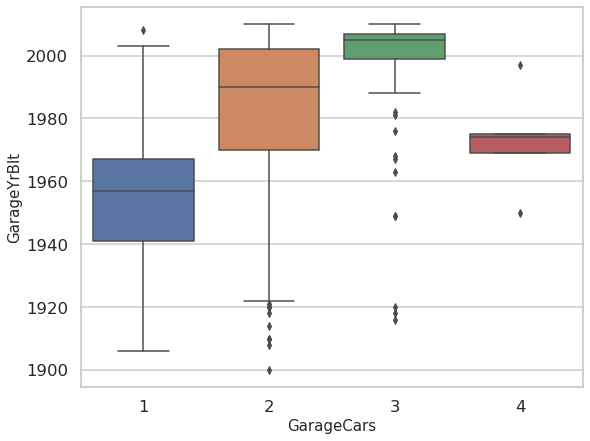

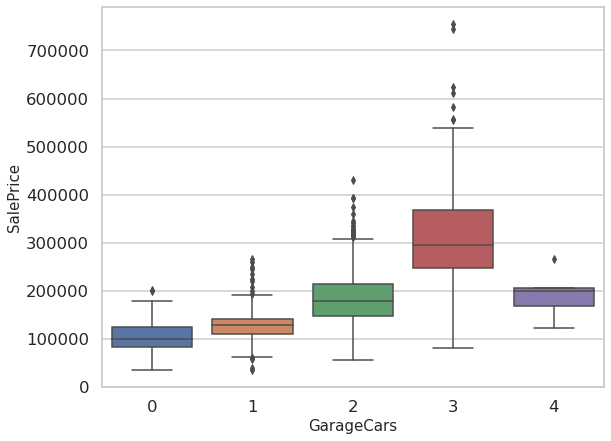

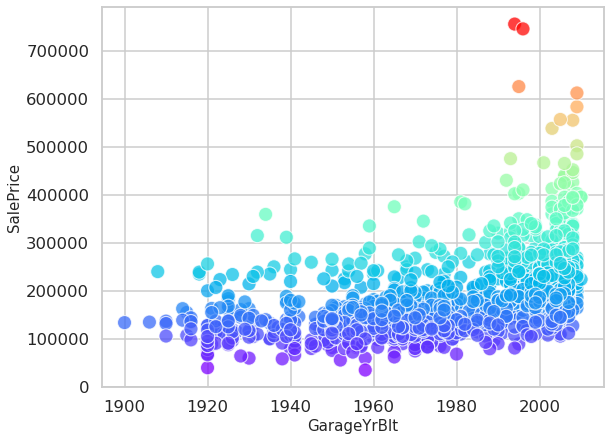

In [22]:
sns.set_theme(style="whitegrid", context="talk")
box_plot("GarageCars", "GarageYrBlt", data[(data.GarageYrBlt > 0) & (data.GarageCars > 0)])
sns.set_theme(style="whitegrid", context="talk")
box_plot("GarageCars", "SalePrice", data)
sns.set_theme(style="whitegrid", context="talk")
scatter_plot("GarageYrBlt", "SalePrice", data[(data.GarageYrBlt > 0)], s=200, alpha=0.75, edgecolors="None", hue="SalePrice",
             palette="rainbow", legend=False)

In [103]:
# # If the P-Value of the Shapiro Wilk Test is larger than 0.05, we assume a normal distribution
# # my_data = norm.rvs(size=500)
# for column in numerical+cat_encoded+["SalePrice"]:
#     if stats.shapiro(data[column])[1] <= 0.05:
# #         print(column + ":\t\t Passed ", stats.shapiro(data[column]))
# #     else:
# #         print(column + ":\t Not passed ", stats.shapiro(data[column]))

/opt/anaconda/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda/lib/python3.8/site-packages/scipy/stats/stats.py:3875: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


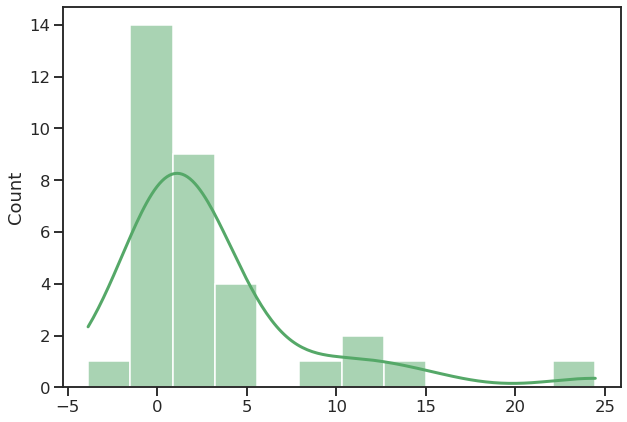

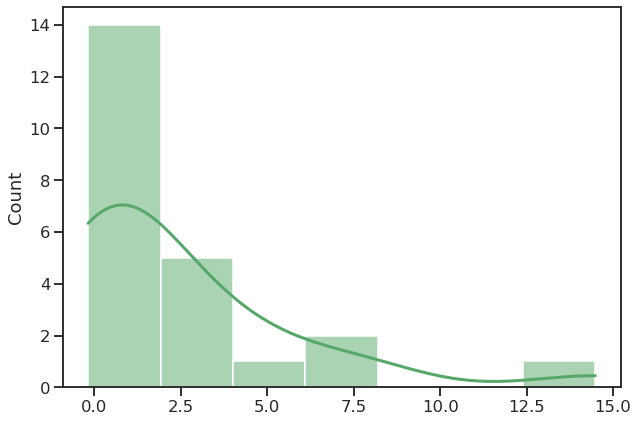

In [29]:
skewness = data[numerical].skew()
skewness.sort_values(inplace=True, ascending=False)
plot_dist(skewness)

skewed_columns = skewness[skewness.values > 0.5].index
boxcox_columns = []
for i in skewed_columns:
    boxcox_columns.append(i + "_boxcox")
    data[i + "_boxcox"] = boxcox1p(data[i], boxcox_normmax(data[i] + 1))

    
#Usar Log
data["SalePrice" + "_boxcox"] = boxcox1p(data["SalePrice"], boxcox_normmax(data["SalePrice"] + 1))
skewness = data[boxcox_columns].skew()
skewness.sort_values(inplace=True, ascending=False)
plot_dist(skewness)

In [30]:
#drop PoolArea, it has 
print(skewness.index[0])
print(data[skewness.index[0]].unique())
numerical.remove(skewness.index[0][:-7])


PoolArea_boxcox
[ 0.         51.24544415 58.39224445 54.70572725 53.5908764  49.4403247
 51.63329533 62.74337954]


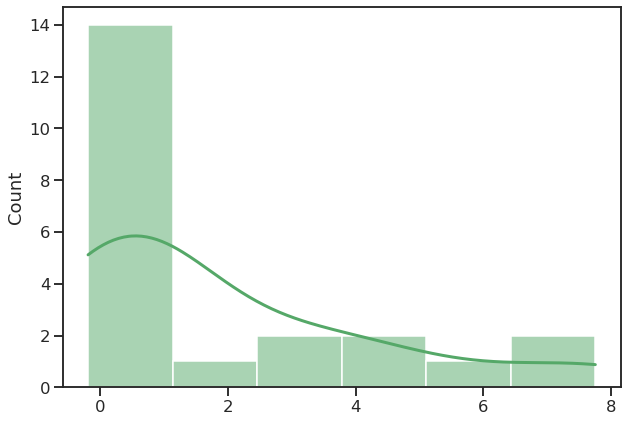

In [31]:
skewness = skewness[1:]
plot_dist(skewness)

In [32]:
boxcox_columns.remove("PoolArea_boxcox")

<ipython-input-5-cf69d51d86c5>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax1 = plt.subplots(1, 1, figsize=figsize)


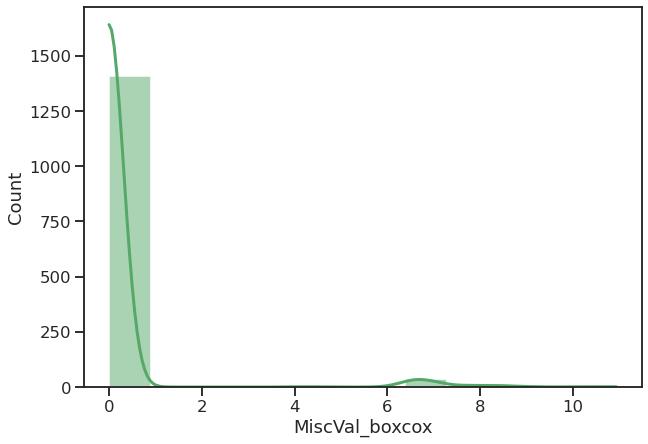

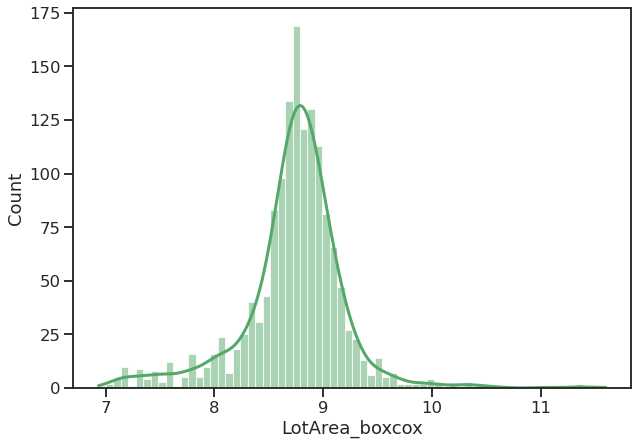

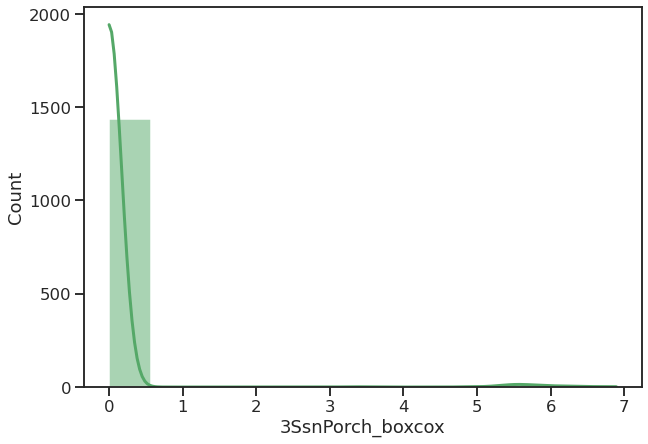

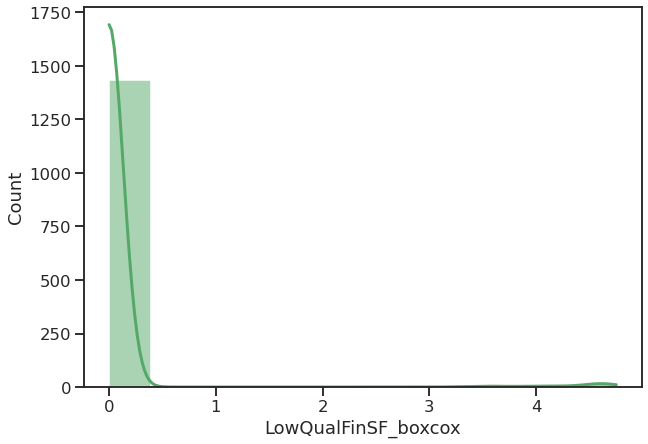

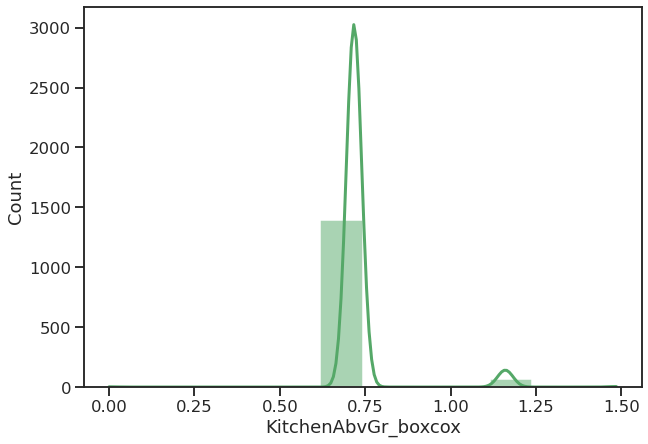

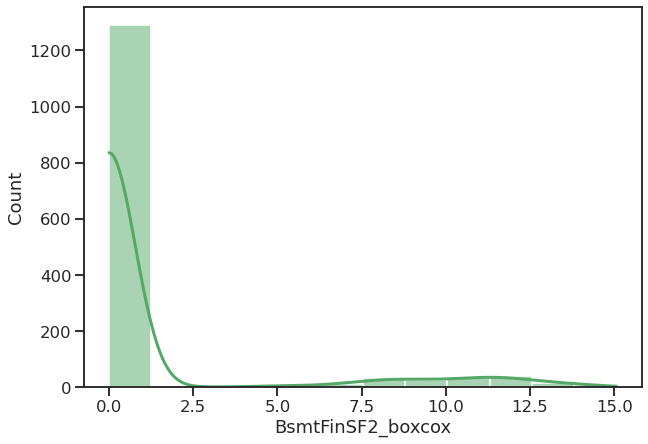

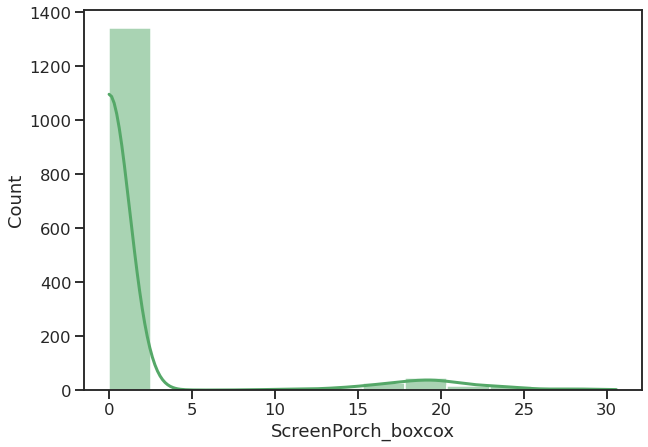

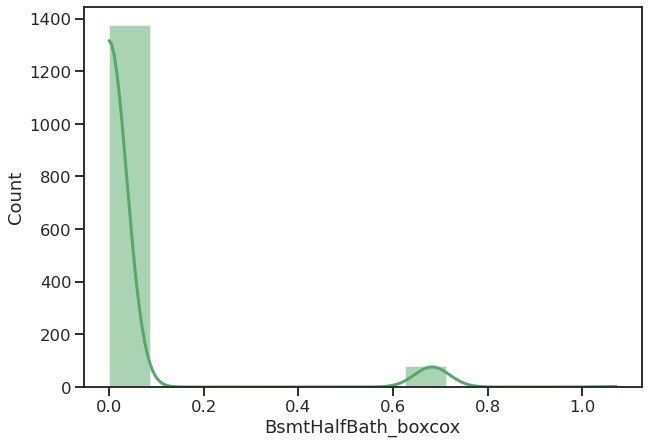

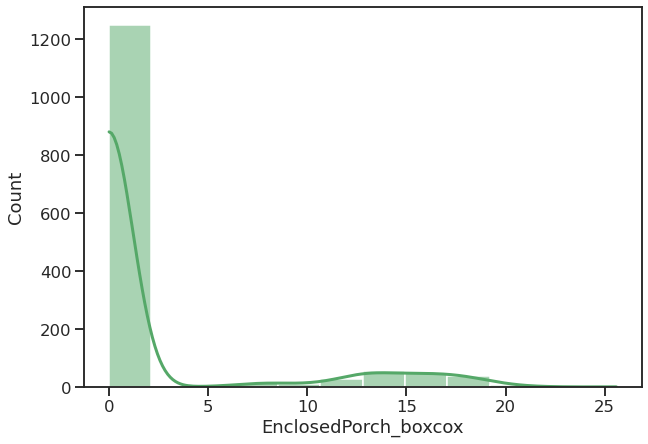

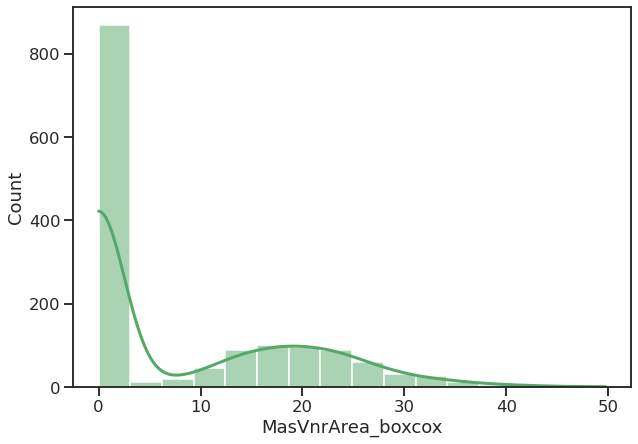

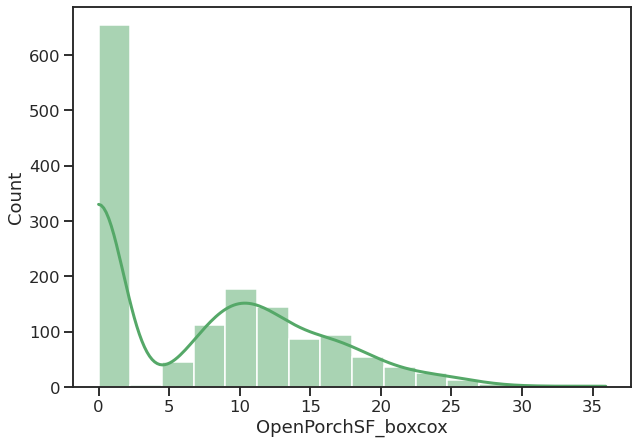

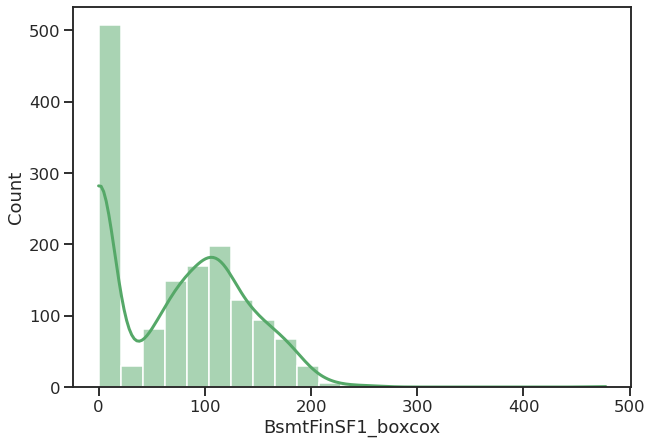

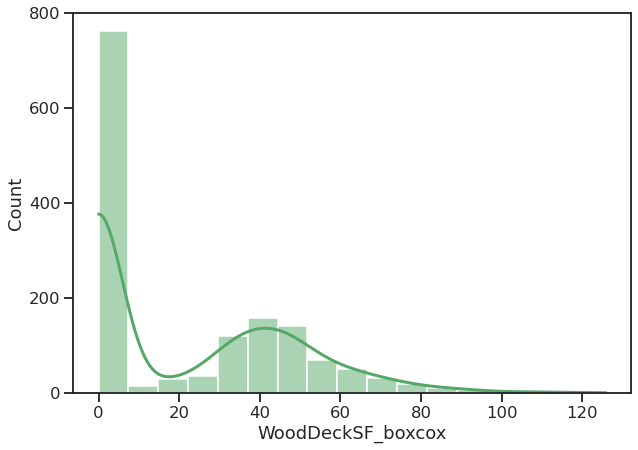

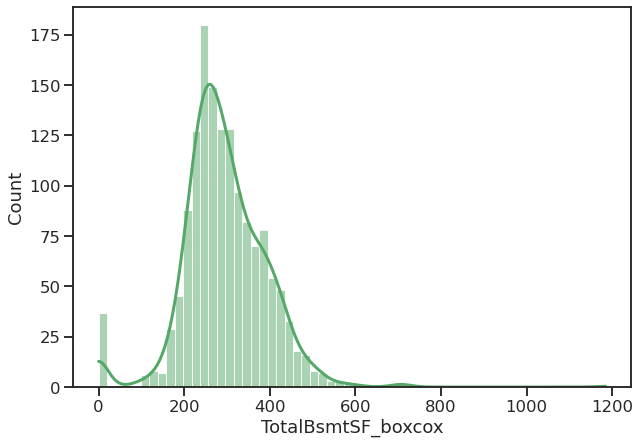

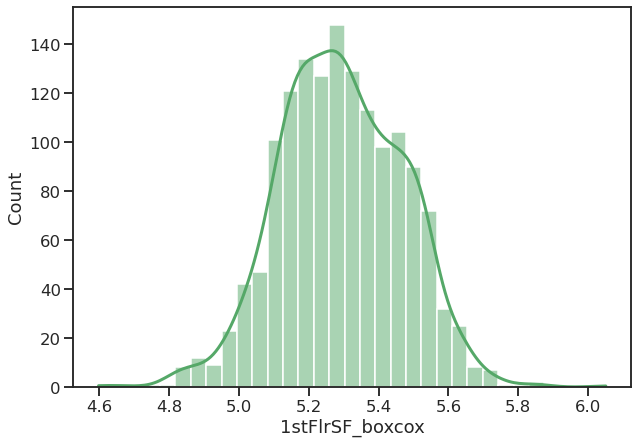

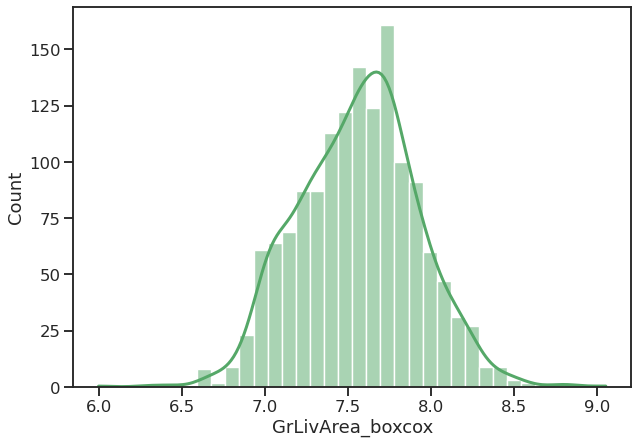

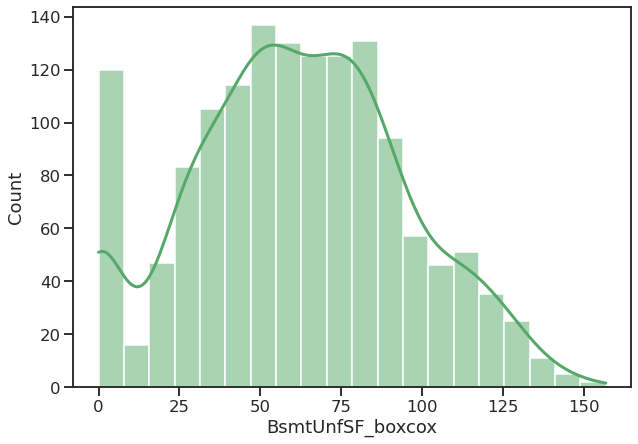

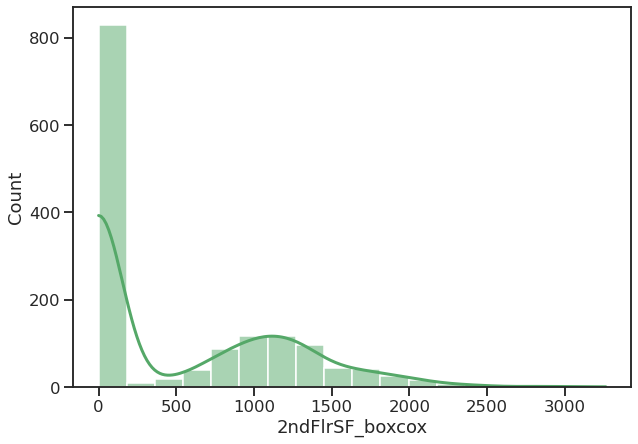

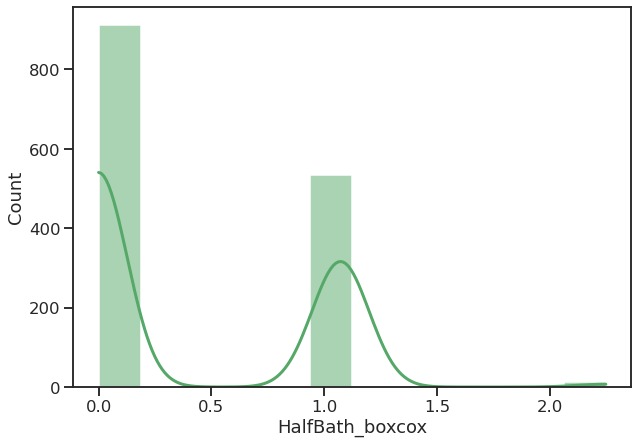

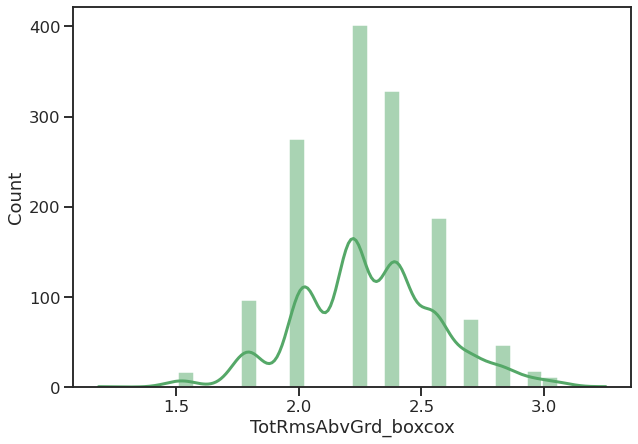

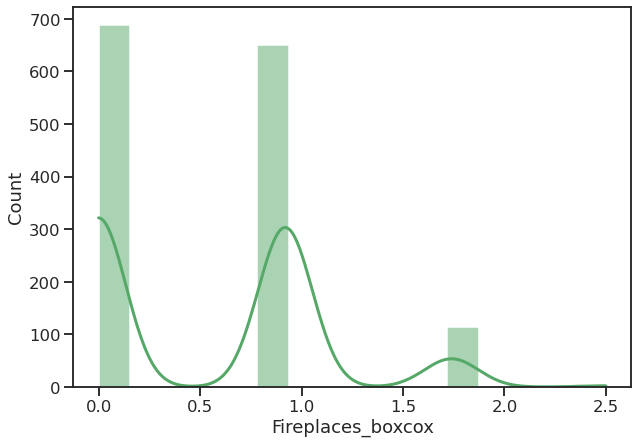

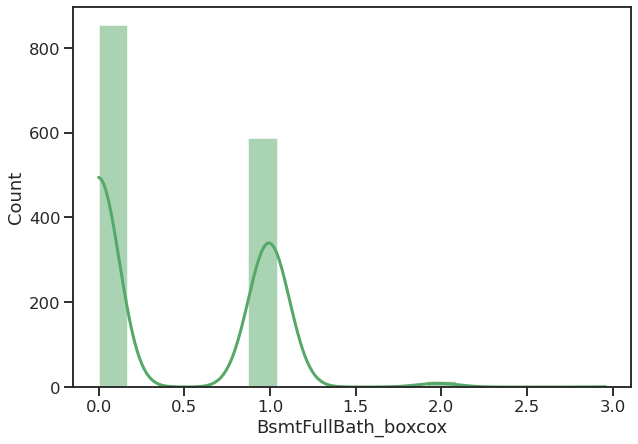

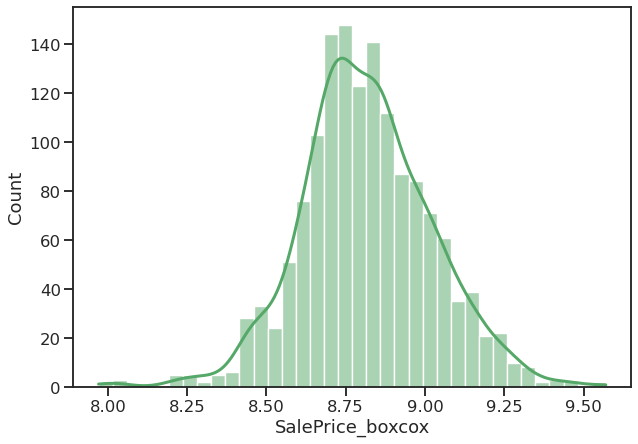

In [33]:
for column in boxcox_columns:
    plot_dist(data[column])
    
plot_dist(data["SalePrice" + "_boxcox"])
# data["LotArea_Log"] = np.log1p(data["LotArea"])
# plot_dist(data["LotArea_Log"])
# data["LotArea_Log"].skew()

[]

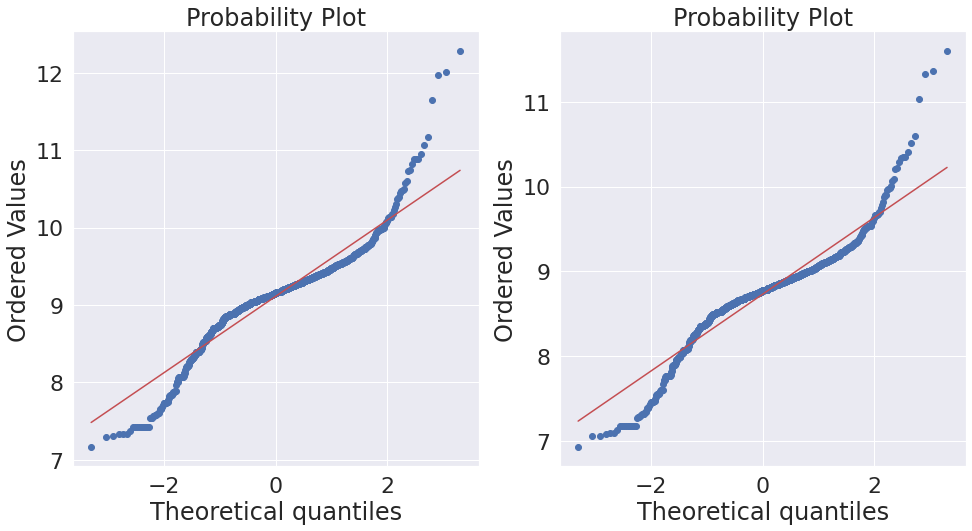

In [34]:
f, ax = plt.subplots(1, 2, figsize=(16, 8))
stats.probplot(np.log1p(data["LotArea"]), plot=ax[0])
stats.probplot(data["LotArea_boxcox"], plot=ax[1])
plt.plot()

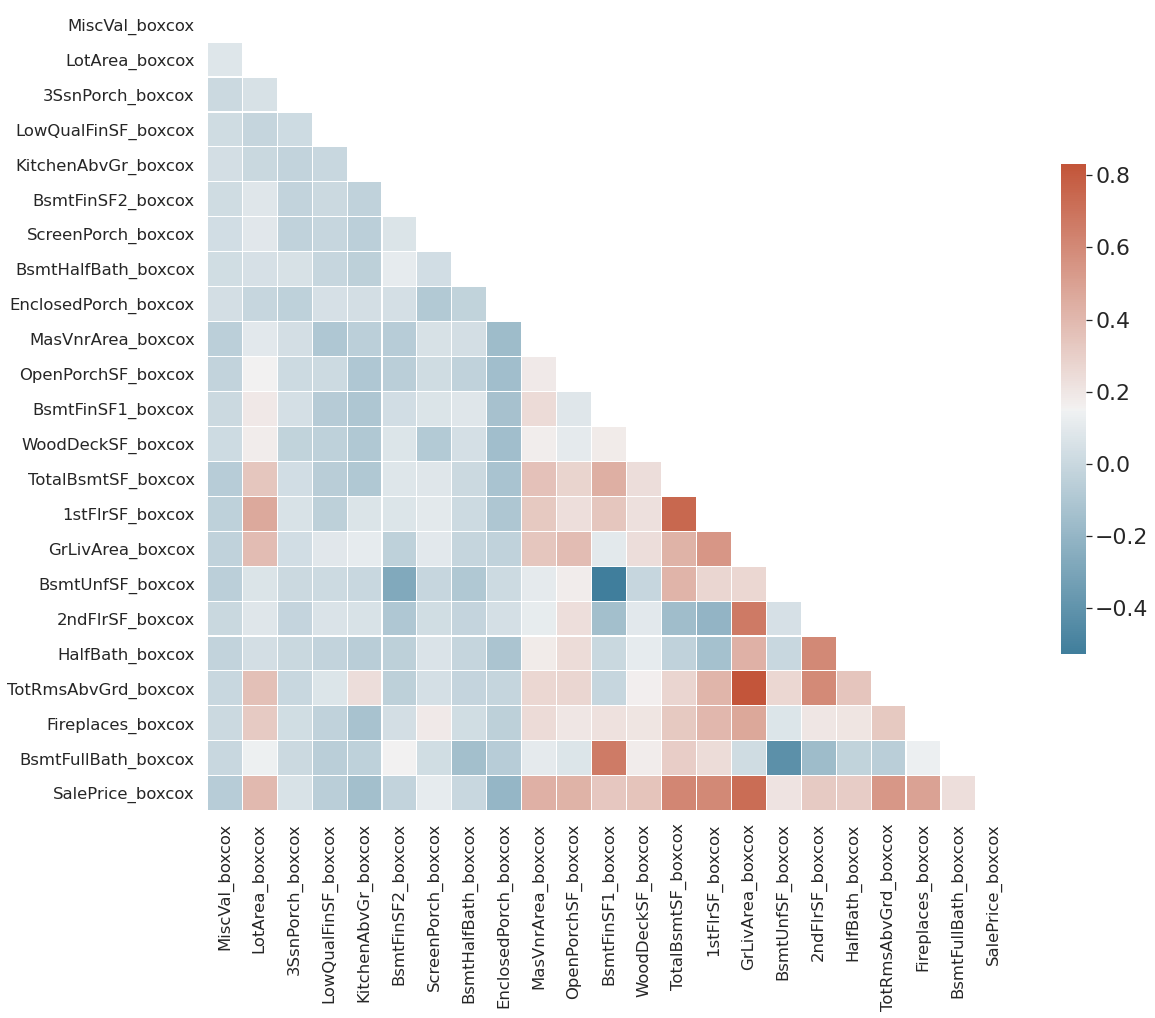

In [35]:
skewed_target = list(boxcox_columns) 
skewed_target.append("SalePrice_boxcox")
skewed_target
sns.set_theme(style="whitegrid", context="talk")
triang_corr_plot(data[skewed_target].corr())
# skewed_columns 

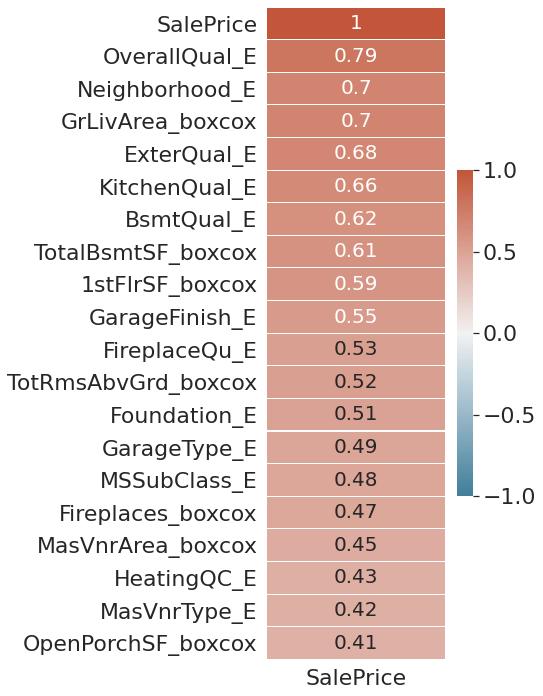

In [36]:
corr_SalePrice = data[boxcox_columns + cat_encoded + ["SalePrice"]].corr()
triang_corr_plot(corr_SalePrice[['SalePrice']].sort_values(by=['SalePrice'],ascending=False).head(20), 
                 vmax=1, vmin=-1, figsize=(4, 12), mask=False, annot=True, annot_kws={"size": 20}, square=False)

Once we have all the NaN values dealt with, we can proceed to split the data in dependent variable and independent variables.
I'll use the conventional notation ```X``` for the independent variables and ```y``` to the dependent.

In [112]:
X = data.copy()
X.drop(labels=["SalePrice"], axis="columns", inplace=True)
X.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,TotalBsmtSF_boxcox,1stFlrSF_boxcox,GrLivArea_boxcox,BsmtUnfSF_boxcox,2ndFlrSF_boxcox,HalfBath_boxcox,TotRmsAbvGrd_boxcox,Fireplaces_boxcox,BsmtFullBath_boxcox,SalePrice_boxcox
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,253.016005,5.152588,7.749663,30.330862,1270.756264,1.071493,2.547432,0.00000,0.99398,8.933223
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,343.382659,5.368817,7.421413,44.715224,0.000000,0.000000,2.217441,0.91963,0.00000,8.861860
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,267.789330,5.193281,7.796741,57.714025,1289.838808,1.071493,2.217441,0.91963,0.99398,8.968770
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,229.442648,5.217769,7.754084,65.781676,1115.626024,0.000000,2.391418,0.91963,0.99398,8.726809
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,318.088312,5.315275,8.021778,62.067006,1589.418826,1.071493,2.689053,0.91963,0.99398,9.025818


In [114]:
y = data["SalePrice_boxcox"].copy()
y.head()

0    8.933223
1    8.861860
2    8.968770
3    8.726809
4    9.025818
Name: SalePrice_boxcox, dtype: float64

**CentralAir** has no need for one-hot encoding

The atributes **GarageType**, **GarageFinish**, **GarageQual**, and **GarageCond** will each generate the "None" column after one-hot encoding, all of them must be droped, except one, since they all will be equal.

The same goes to **BsmtCond**, **BsmtExposure**, **BsmtQual** (but have to pay attention to **BsmtFinType2** and **BsmtFinType1** to see their relationship)


Above grade (ground) living area square feet
Size of garage in car capacity
Original construction date
YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)

In [9]:
#  I have to group the data by ea
date_heatmap = data.groupby(["YrSold", "MoSold"]).count()
date_heatmap = date_heatmap[["SalePrice"]].pivot(index="MoSold", columns="YrSold", values="SalePrice")
 numerical
ax = sns.heatmap()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,12,2008,WD,Normal


0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64